In [221]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, ClassicalRegister
from qiskit_aer import QasmSimulator
import qiskit_aer
import qiskit_aer.primitives
from qiskit_aer import Aer
from qiskit_aer.primitives import SamplerV2
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeValenciaV2
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_qsphere, plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit.quantum_info import state_fidelity
#import matplotlib as plt
import matplotlib.pyplot as plt

sim = AerSimulator()
sim_statevector = AerSimulator(method='statevector')


In [161]:
def create_circuit(theta):
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.ry(theta, 0)
    circuit.cx(0, 1)  # CNOT gate, where qubit 0 controls qubit 1
    circuit.rx(theta, 0)
    circuit.measure_all()
    return circuit
qc=create_circuit(0)
qc.draw()

┌───┐┌───────┐     ┌───────┐ ░ ┌─┐   
   q_0: ┤ H ├┤ Ry(0) ├──■──┤ Rx(0) ├─░─┤M├───
        └───┘└───────┘┌─┴─┐└───────┘ ░ └╥┘┌─┐
   q_1: ──────────────┤ X ├──────────░──╫─┤M├
                      └───┘          ░  ║ └╥┘
meas: 2/════════════════════════════════╩══╩═
                                        0  1

In [178]:
def cost_function(theta):
    circuit = create_circuit(theta)
    circuit.measure_all()  # Measure all qubits

    # Use the Aer simulator
    backend = Aer.get_backend('aer_simulator') #Aer.get_backend('qasm_simulator')
    job = transpile(circuit, backend)
    result_run=backend.run(circuit, shots=1024)
    result = result_run.result()#.get_counts()

    # Get counts and calculate cost (e.g., probability of measuring |1>)
    counts = result.get_counts(circuit)
    #prob_one = counts.get('0', 0) / 1024  # Probability of measuring |1>
   #print("Measurement outcomes:", counts)
    prob_00 = counts.get('00 00', 0) / 1024
    prob_11 = counts.get('11 11', 0) / 1024
    prob_01 = counts.get('01 01', 0) / 1024
    prob_10 = counts.get('10 10', 0) / 1024
   # print(prob_00,prob_11,prob_01,prob_10)
    return prob_11 #+ prob_11 #+ prob_01 + prob_10
    #return prob_one
#cost_function(np.pi)

In [179]:
cost = cost_function(np.pi/2)
print(cost)

0.50390625


In [180]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0

    def update(self, theta, grad):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)

        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)

        theta -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return theta

In [201]:
theta = np.pi/2  # Initial parameter
optimizer = AdamOptimizer(lr=0.1)
tol=1e-6

for epoch in range(30):  # Number of iterations
    cost = cost_function(theta)
    grad = (cost_function(theta + 1e-5) - cost) / 1e-1  # Numerical gradient approximation
    theta = optimizer.update(theta, grad)

   # if abs(new_theta - theta) < tolerance:  # Check for convergence
     #   print("Optimal theta found:", new_theta)
     #   break
    if epoch==0:
        old_theta=theta
    else:
        old_theta=theta
   # theta = new_theta
    print(f"Epoch {epoch}, Theta: {theta}, tol: Theta: {new_theta-theta} Cost: {cost}, Gradient: {grad}")

Epoch 0, Theta: 1.6707962755949228, tol: Theta: -1.6707962755949228 Cost: 0.505859375, Gradient: -0.01953125
Epoch 1, Theta: 1.7534092175265032, tol: Theta: -1.7534092175265032 Cost: 0.474609375, Gradient: -0.146484375
Epoch 2, Theta: 1.7162432603253517, tol: Theta: -1.7162432603253517 Cost: 0.3974609375, Gradient: 0.390625
Epoch 3, Theta: 1.6664777352778464, tol: Theta: -1.6664777352778464 Cost: 0.4072265625, Gradient: 0.166015625
Epoch 4, Theta: 1.6280555972713082, tol: Theta: -1.6280555972713082 Cost: 0.44921875, Gradient: -0.029296875
Epoch 5, Theta: 1.605570100189502, tol: Theta: -1.605570100189502 Cost: 0.4921875, Gradient: -0.087890625
Epoch 6, Theta: 1.5608090992317027, tol: Theta: -1.5608090992317027 Cost: 0.4716796875, Gradient: 0.3125
Epoch 7, Theta: 1.5065966674315752, tol: Theta: -1.5065966674315752 Cost: 0.5126953125, Gradient: 0.205078125
Epoch 8, Theta: 1.464409034336613, tol: Theta: -1.464409034336613 Cost: 0.5322265625, Gradient: -0.068359375
Epoch 9, Theta: 1.4316926

1e-06


In [124]:
    circuit = create_circuit(theta)
    circuit.measure_all()  # Measure all qubits

    # Use the Aer simulator
    backend = Aer.get_backend('aer_simulator') #Aer.get_backend('qasm_simulator')
    job = transpile(circuit, backend)
    result_run=backend.run(circuit, shots=1024)
    result = result_run.result()#.get_counts()

    # Get counts and calculate cost (e.g., probability of measuring |1>)
    counts = result.get_counts(circuit)
    #prob_one = counts.get('0', 0) / 1024  # Probability of measuring |1>
    print("Measurement outcomes:", counts)
    prob_00 = counts.get('00 00', 0) / 1024
    prob_11 = counts.get('11 11', 0) / 1024
    prob_01 = counts.get('01 01', 0) / 1024
    prob_10 = counts.get('10 10', 0) / 1024
    #print(prob_00,prob_11,prob_01,prob_10)
    #print(counts.get('00', 0) / 1024)


Measurement outcomes: {'00 00': 522, '11 11': 502}
0.509765625 0.490234375 0.0 0.0


In [208]:
tolerance = 1e-5  # Define tolerance
dat=[]
for epoch in range(1000):
    cost = cost_function(theta)
    grad = (cost_function(theta + 1e-3) - cost_function(theta - 1e-3)) / (2 * 1e-3)
    new_theta = optimizer.update(theta, grad)

    if abs(new_theta - theta) < tolerance:  # Check for convergence
        print("Optimal theta found:", new_theta)
        print(f"Final params: Epoch {epoch}, Theta: {theta}, tol: Theta: {new_theta-theta} Cost: {cost}, Gradient: {grad}")
        break
    dat.append((epoch,theta, abs(new_theta-theta),cost,grad))
    #print(f"Epoch {epoch}, Theta: {theta}, tol: Theta: {new_theta-theta} Cost: {cost}, Gradient: {grad}")
    theta = new_theta

Optimal theta found: -1.5958106058362087
Final params: Epoch 247, Theta: -1.595805119469027, tol: Theta: -5.4863671816729465e-06 Cost: 0.0, Gradient: -0.48828125


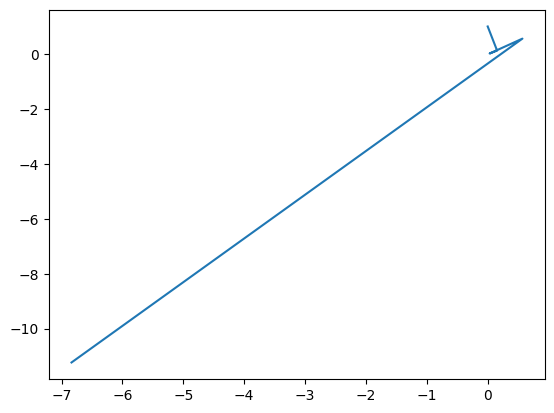

In [247]:
epochs=[]
thetas=[]
costs=[]
gradients=[]
for i in range(len(dat)):
    #print(dat[i][0],dat[i][1],dat[i][3],dat[i][4])
    epochs.append(dat[i][0])
    thetas.append(dat[i][1])
    costs.append(dat[i][3])
    gradients.append(dat[i][4])

ValueError: x and y must have same first dimension, but have shapes (1,) and (247,)

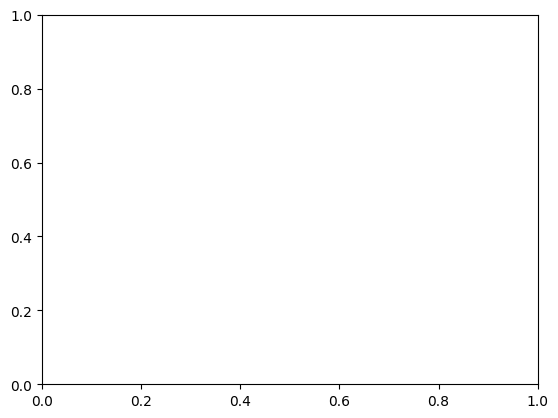

In [253]:
plt.plot(epoch,gradients)